# Hidden Markov Model Tutorial Notebook #

This notebook will show you how to create Hidden Markov Models (HMMs) using StateSpaceDynamics.jl.  Hidden Markov Models are a type of state space model with discrete latent state transitions. We will not go deep into the theory on how HMMs are trained, but we recommend checking out Chapter 13 of Pattern Recognition and Machine Learning by Christopher Bishop for this.

## 0. Environment Setup ##

In [1]:
using Pkg
using LinearAlgebra
using Plots
using Distributions
using Random
using StateSpaceDynamics
using StatsBase

const SSD = StateSpaceDynamics

StateSpaceDynamics

## 1. Introduction to Hidden Markov Models (HMMs)

Hidden Markov Models (HMMs) are a type of probabilistic graphical model commonly used for modeling time-series data or sequences where the underlying system is assumed to follow discrete, unobservable states. These states evolve over time, generating observable data, often referred to as "emissions."

#### Fundamental Assumptions of HMMs

1. **Discrete Hidden State Variable:**  
   HMMs assume the existence of a hidden state variable $z_t$ at each time step $t$. This variable can take on one of $K$ discrete values (or states). For example, $z_t \in \{z_1, z_2, \ldots, z_K\}$.

2. **First-Order Markov Property:**  
   The hidden state variable evolves according to a first-order Markov chain, meaning the probability of transitioning to the current state depends only on the previous state. Mathematically, this can be expressed as:

   $P(z_t | z_{t-1}, z_{t-2}, \ldots) = P(z_t | z_{t-1})$
   
3. **Observations Dependent on Hidden States:**  
   We do not directly observe the hidden states $z_t$; instead, we observe some data $x_t$ (the emission) that depends probabilistically on the hidden state at that time. 

#### Key Parameters of HMMs

HMMs are characterized by three sets of parameters:

1. **Initial State Distribution ($\pi$)**  
   The initial state distribution $\pi$ specifies the probability of the model starting in each possible state. For a state $z_k$, the probability of starting in this state is given by:

   $\pi_k = P(z_1 = z_k)$

   where $\sum_{k=1}^{K} \pi_k = 1$

2. **Transition Matrix ($A$)**  
   The transition matrix $A$ defines the probabilities of transitioning from one state to another. Each element $A_{jk}$ in the matrix represents the probability of transitioning from state $z_j$ at time $t-1$ to state $z_k$ at time $t$:

   $A_{jk} = P(z_t = z_k | z_{t-1} = z_j)$

   where $\sum_{k=1}^{K} A_{jk} = 1$ for each $j$

3. **Observation Model ($P(x|z, \phi)$)**  
   The observation model specifies the likelihood of observing the data $x_t$ given the current hidden state $z_t$ and a set of emission parameters $\phi$. The choice of observation model depends on the type of data:

   - **Discrete emissions:** Use a categorical distribution.
   - **Continuous emissions:** Use a Gaussian distribution (common) or another continuous distribution.
   
   For example, if the emissions are Gaussian, the observation model is given by:

   $P(x_t | z_t = z_k, \phi_k) = \mathcal{N}(x_t| \mu_k, \Sigma_k)$

   where $\mu_k$ and $\Sigma_k$ are the mean and covariance matrix for state $z_k$.


### Example

In the example below, we show how to initialize an HMM using StateSpaceDynamics.jl. In the example, we create an HMM with Gaussian emisisons that has 2 latent states.



In [2]:
# Create a Gaussian Emission model for each latent state (K=2 in this example)
output_dim = 2
μ = [0.0, -1.0]
Σ = 1 * Matrix{Float64}(I, output_dim, output_dim)
emission_1 = GaussianEmission(Gaussian(output_dim=output_dim, μ=μ, Σ=Σ))

μ = [5.0, 3.0]
Σ = 1.5 * Matrix{Float64}(I, output_dim, output_dim)
emission_2 = GaussianEmission(Gaussian(μ=μ, Σ=Σ, output_dim=output_dim))

# Create the HMM, specifying the number of latent states and the dimensionality of the emissions
true_model = SSD.GaussianHMM(K=2, output_dim=2)

# Assign the emission models to the HMM. To access the emission models in StateSpaceDynamics.jl -> model_name.B
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Assign the transition matrix and the initial state distribution
true_model.A = [0.95 0.05; 0.1 0.9]
true_model.πₖ = [0.6; 0.4]

2-element Vector{Float64}:
 0.6
 0.4

## 2. Sampling from an HMM

Now that we have an HMM, we can draw samples from it. To do this we use the `sample` method. Just pass the model name and the number of samples you wish to have and the function will return the latent states and the corresponding emissions.

In [3]:
# Sample from the model
n=300
true_labels, data = SSD.sample(true_model, n=n)

# We can evaluate the log likelihood of the data
d = (data,)
γ, ξ, α, β = E_step(true_model, d)
ll_true = SSD.logsumexp(α[end, :])
println("Log Likelihood of Synthetic Data given True Model: ", ll_true)

Log Likelihood of Synthetic Data given True Model: -949.1698066318584


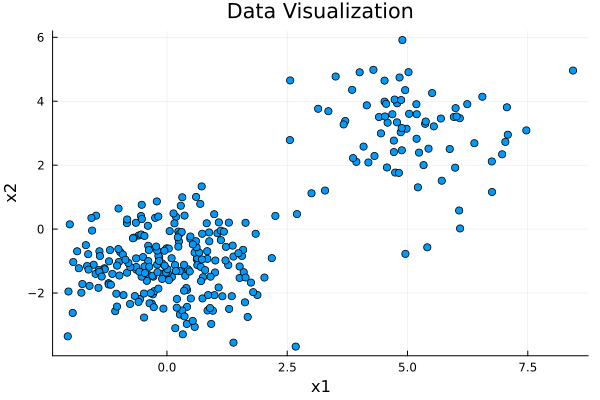

In [4]:
plot(data[1:end, 1], data[1:end, 2], seriestype=:scatter, label=false)
title!("Data Visualization")
xlabel!("x1")
ylabel!("x2")

## 3. Fitting an HMM

To fit an HMM, you can use the `fit!` function. As an example, we will initialize a new gaussian HMM and fit it to the synthetic data we generated by sampling! The fit function has option arugments for max_iters and tol to specify training preferences.

In [5]:
# Initialize a new GaussianHMM
test_model = SSD.GaussianHMM(K=2, output_dim=2)

# Call the fit function, which returns a vector of the training log likelihoods
ll = SSD.fit!(test_model, data)

New Function in use...


Running EM algorithm...   2%|█                           |  ETA: 0:01:48

Running EM algorithm... 100%|████████████████████████████| Time: 0:00:02


15-element Vector{Float64}:
   -Inf
 -2382.3126905395116
 -1204.8898066925874
 -1204.6051106905275
 -1203.6643595195937
 -1200.2561005372734
 -1186.899961738224
 -1129.3226791557609
  -996.11377745442
  -956.5291654901346
  -945.4846911022807
  -944.8169389016856
  -944.8087550855985
  -944.8087037226362
  -944.808703429293

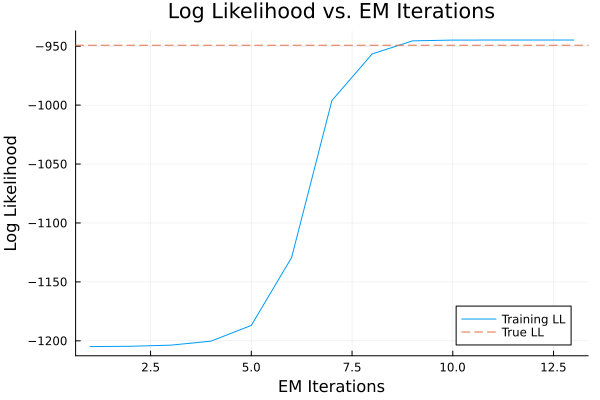

In [13]:
# Plot the log likelihood vs EM iterations
plot(ll[3:end], label=:"Training LL")
hline!([ll_true], linestyle=:dash, label=:"True LL")
title!("Log Likelihood vs. EM Iterations")
xlabel!("EM Iterations")
ylabel!("Log Likelihood")

## 4. Model Evaluation and Simple Visualizations

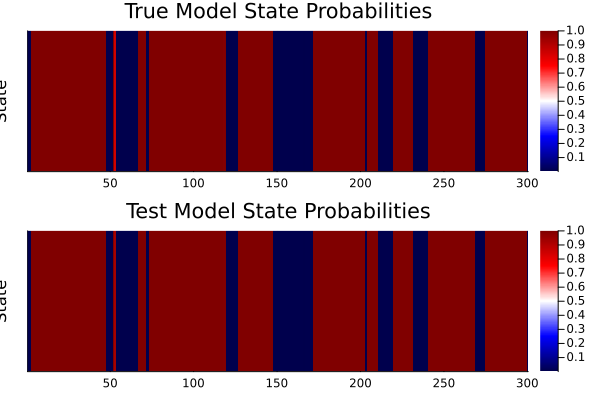

In [7]:
# Compute posterior probabilities
true_probabilities = class_probabilities(true_model, data)
test_probabilities = class_probabilities(test_model, data)

# Create the heatmaps without y-axis ticks
p1 = heatmap(true_probabilities[1:end, 1]', title = "True Model State Probabilities", color=:seismic, yticks=false)
p2 = heatmap(test_probabilities[1:end, 1]', title = "Test Model State Probabilities", color=:seismic, yticks=false)

# Combine the heatmaps with a single y-axis label
plot(p1, p2, layout = @layout([a; b]), ylabel="State")


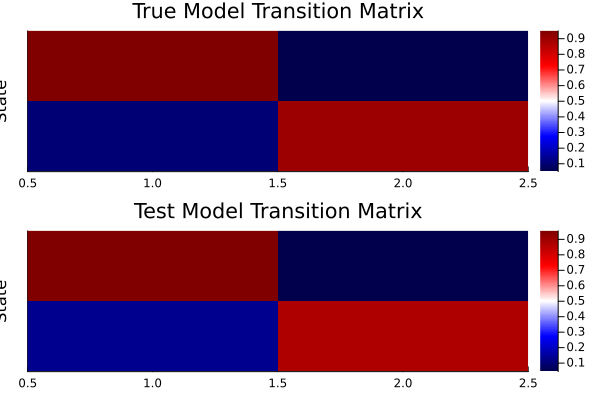

In [8]:
# Create the heatmaps without y-axis ticks
p1 = heatmap(true_model.A, title = "True Model Transition Matrix", color=:seismic, yticks=false, yflip=true)
p2 = heatmap(test_model.A, title = "Test Model Transition Matrix", color=:seismic, yticks=false, yflip=true)

# Combine the heatmaps with a single y-axis label
plot(p1, p2, layout = @layout([a; b]), ylabel="State")